In [10]:


# Basic python libraries
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

# DL libraries
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, concatenate, Reshape, Dropout, Conv2D, MaxPool2D, Flatten, Input, Multiply, Bidirectional, BatchNormalization
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, Model
from tensorflow.keras.applications import VGG16

# Helper libraries
from scipy import io
import h5py
import pickle

# NLP libraries
from nltk import word_tokenize
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd
import json
import random
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from wordcloud import WordCloud



[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Read a file line by line and convert it into a numpy array of a specified type
def read_file(path, dtype):
    return np.asarray([line.strip() for line in open(path)], dtype=dtype)

# Create a DataFrame from files in a given folder, with columns for image IDs, types, questions, and answers
def create_dataframe(folder):
    return pd.DataFrame({
        'image_id': read_file(str(folder) + '/img_ids.txt', 'int64'),
        'type': read_file(str(folder) + '/types.txt', 'int8'),
        'question': read_file(str(folder) + '/questions.txt', 'str'),
        'answer': read_file(str(folder) + '/answers.txt', 'str')
    })

In [12]:
# Try to create a directory for preprocessing, ignore if it already exists
try:
    os.makedirs('preprocessing/COCO-QA')
except:
    pass

# Try to create a directory for top answers, ignore if it already exists
try:
    os.makedirs('answers_dir')
except:
    pass

# Try to create a directory for embeddings, ignore if it already exists
try:
    os.makedirs('mat_saves/')
except:
    pass

# Try to create a directory for storing model weights, ignore if it already exists
try:
    os.makedirs('model_weights/')
except:
    pass

In [13]:
# Load training and validation data into DataFrame from specified paths
train_data = create_dataframe('/kaggle/input/coco-toronto/cocoqa-2015-05-17/train')
val_data = create_dataframe('/kaggle/input/coco-toronto/cocoqa-2015-05-17/test')

In [14]:
#Extracts VGG features for the images specified in the data
def get_feat(database):
    # Read coco to the vgg mapping file to get map of vgg index and coco images
    img_ids = open('/kaggle/input/vqa-inference/vgg_feats/coco_vgg_IDMap.txt').read().splitlines()
    id_map = {int(ids.split()[0]): int(ids.split()[1]) for ids in img_ids}

    # get features for images using id map
    VGGfeatures = io.loadmat('/kaggle/input/vqa-inference/vgg_feats/vgg_feats.mat')['feats']
    return np.array([VGGfeatures[:, id_map[img_id]] for img_id in database['image_id'].tolist()])

In [15]:
# Define an LSTM model for VQA with pre-trained embeddings
def lstm_model(num_classes, vocab_size, embedding_matrix):

    # Define inputs: one for text and one for image features
    text_input = Input(shape=(None,))
    image_input = Input(shape=(4096,))

    # Embedding layer using pre-trained embeddings, set to non-trainable
    embedding_layer = Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1],
        weights = [embedding_matrix],
        trainable = False
    )(text_input)

    # LSTM layer to process the embedded text, capturing hidden and cell states
    _, hidden_state, cell_state = LSTM(512, return_state=True)(embedding_layer)

    # Combine the LSTM outputs with the image features, followed by dense layers and dropout for regularization
    x = Multiply()([concatenate([cell_state, hidden_state]), Dense(units=1024, activation='tanh')(image_input)])
    x = Dropout(0.5)(x)
    x = Dense(1000, activation='tanh')(x)
    x = Dropout(0.5)(x)
    # Output layer with softmax activation for classification
    x = Dense(num_classes, activation='softmax')(x)

    # Construct the model with image and text inputs
    return Model(inputs = [image_input, text_input], outputs = x)

In [16]:
# Combine answers from train and validation sets, and count occurrences of each unique answer
answers = list(train_data['answer']) + list(val_data['answer'])

counts = {}
# Count the frequency of each answer, converting them to lowercase for consistency
for ans in answers:
    if ans.lower() in counts:
        counts[ans.lower()] += 1
    else:
        counts[ans.lower()] = 1

# Select the top 1000 most frequent answers
bestAnswers = [word for word, j in sorted(counts.items(), key=lambda value: value[1], reverse=True)[:1000]]

In [17]:
# Write the top answers to a file
with open('answers_dir/mode_answers.txt', 'w') as f:
    results = '\n'.join(bestAnswers)
    f.write(results)

# Create a dictionary mapping top answers to their indices
map1 = dict(zip(bestAnswers, range(len(bestAnswers))))
# Filter the train and validation datasets to only include data with top answers
preprocessed_train = train_data.iloc[[i for i, ans in enumerate(train_data['answer']) if ans in map1]]
preprocessed_val = val_data.iloc[[i for i, ans in enumerate(val_data['answer']) if ans in map1]]

In [18]:
# Tokenize and lower-case questions from the filtered train and validation sets, and count word occurrences
words = [word for q in (preprocessed_train['question'].tolist() + (preprocessed_val['question'].tolist() if preprocessed_val.size != 0 else [])) for word in word_tokenize(q.lower())]
counts = Counter(words)
# Create a vocabulary of words present in the questions
vocab = [word for word, count in counts.items() if count > 0]
# Assign an index to each word in the vocabulary
word_idx = {word: idx+1 for idx, word in enumerate(vocab)}

# Create an embedding matrix for the vocabulary, initializing with zeros
embedding_matrix = np.zeros((len(vocab) + 1, 300))
# Load GloVe embeddings and assign them to the respective words in the vocabulary
with open('/kaggle/input/vqa-data/results/embeddings/glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        if values[0] in word_idx:
            embedding_matrix[word_idx[values[0]]] = np.asarray(values[1:], dtype='float32')

# Save the word to index mapping for future use
with open('mat_saves/word_idx','wb') as f:
    pickle.dump(word_idx,f)

In [19]:
# Convert questions from the filtered train and validation sets to sequences of indices, padding where necessary
q_train = pad_sequences([[word_idx.get(word, 0) for word in word_tokenize(q.lower())] for q in preprocessed_train['question']])
q_val = pad_sequences([[word_idx.get(word, 0) for word in word_tokenize(q.lower())] for q in preprocessed_val['question']])

# Create a dictionary to convert answers to one-hot encoded vectors based on the number of top answers
encoded_dictionary = {ans: np.eye(len(bestAnswers))[i] for i, ans in enumerate(bestAnswers)}

# Convert answers in the filtered train and validation datasets to one-hot encoded vectors
answers_train = np.array([encoded_dictionary[ans.lower()] for ans in preprocessed_train['answer']])
answers_val = np.array([encoded_dictionary[ans.lower()] for ans in preprocessed_val['answer']])

# Extract image features for the training and validation datasets
img_features_train = get_feat(preprocessed_train)
img_features_val = get_feat(preprocessed_val)

In [20]:
# Initialize the LSTM model with the number of answer classes, vocabulary size, and embedding matrix
model = lstm_model(num_classes=len(bestAnswers), vocab_size=len(word_idx)+1, embedding_matrix=embedding_matrix)
# Compile the model with the Adam optimizer and categorical crossentropy as the loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model on the training data and validate on the validation data
model.fit([img_features_train, q_train],answers_train, epochs=10, batch_size=128, validation_data=([img_features_val, q_val],answers_val), verbose=1)
# Save the trained model weights
model.save('model_weights/lstm_coco.h5')

Epoch 1/10
616/616 [==============================] - 23s 28ms/step - loss: 2.7798 - accuracy: 0.3675 - val_loss: 2.0578 - val_accuracy: 0.4819
Epoch 2/10
616/616 [==============================] - 15s 25ms/step - loss: 2.0553 - accuracy: 0.4768 - val_loss: 1.8390 - val_accuracy: 0.5221
Epoch 3/10
616/616 [==============================] - 15s 25ms/step - loss: 1.8539 - accuracy: 0.5137 - val_loss: 1.7665 - val_accuracy: 0.5377
Epoch 4/10
616/616 [==============================] - 15s 25ms/step - loss: 1.7185 - accuracy: 0.5390 - val_loss: 1.7345 - val_accuracy: 0.5458
Epoch 5/10
616/616 [==============================] - 15s 25ms/step - loss: 1.6251 - accuracy: 0.5554 - val_loss: 1.7218 - val_accuracy: 0.5539
Epoch 6/10
616/616 [==============================] - 15s 25ms/step - loss: 1.5409 - accuracy: 0.5711 - val_loss: 1.7201 - val_accuracy: 0.5549
Epoch 7/10
616/616 [==============================] - 15s 24ms/step - loss: 1.4596 - accuracy: 0.5890 - val_loss: 1.7255 - val_accuracy:

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# Define a function to get the top 5 predicted answers for a given image and question
def get_answer(img_path, question):

    # Load the list of top answer classes and word-to-index mapping
    with open('/kaggle/working/answers_dir/mode_answers.txt', 'r') as f:
        top_answers_classes = [line.strip() for line in f]

    with open('/kaggle/working/mat_saves/word_idx', 'rb') as f:
        word_idx = pickle.load(f)

    # Load pre-trained VGG16 model and create a model to extract features from the last FC layer
    vgg_model = VGG16(weights='imagenet', include_top=True)
    features_model = Model(inputs=vgg_model.input, outputs=vgg_model.layers[-1].input)

    # Preprocess the input image and extract features
    feature_list = [preprocess_input(np.expand_dims(image.img_to_array(image.load_img(img_path, target_size=(224, 224))), axis=0))]
    img_features = features_model([feature_list], training=False)

    # Tokenize and encode the question
    tok_list = word_tokenize(question.lower())
    question_sequence = np.reshape([word_idx.get(token, 0) for token in tok_list], (1, len(tok_list)))

    # Load the trained LSTM model and predict the answer
    loaded_model = load_model('/kaggle/working/model_weights/lstm_coco.h5')
    answers_ids = np.argsort(loaded_model.predict([img_features, question_sequence])[0])[::-1]

    # Return the top 5 predicted answers
    return [top_answers_classes[answers_ids[i]] for i in range(5)]

1/1 [==============================] - 0s 363ms/step


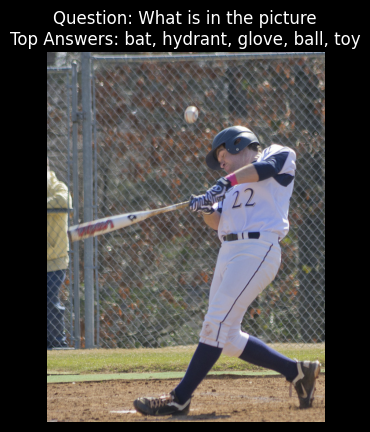

In [28]:
# Example usage of the function
image_path = '/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000016.jpg'
question = 'What is in the picture'

# Display the image with the question and top answers
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Question: {question}\nTop Answers: {', '.join(get_answer(image_path, question))}")
plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 300)            3611700   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 512),                1665024   ['embedding[0][0]']           
                              (None, 512),                                                        
                              (None, 512)]                                                        
                                                                                              

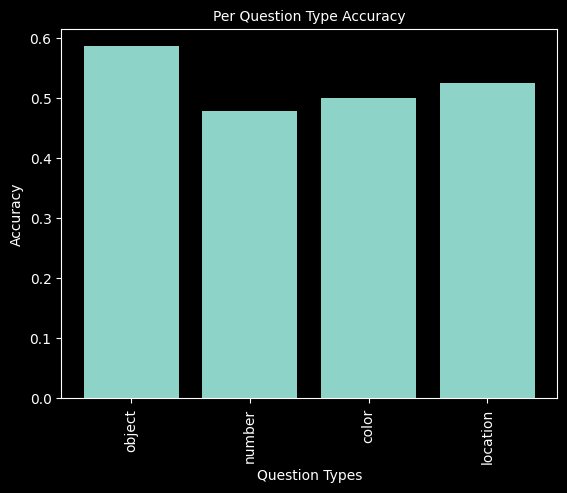

Overall:  0.5596436262130737
object:  0.5855326056480408
number:  0.4780399203300476
color:  0.4990013837814331
location:  0.5254237055778503


In [22]:
model_path = f'/kaggle/working/model_weights/lstm_coco.h5'
model = load_model(model_path)

val_data = preprocessed_val


word_idx = "/kaggle/working/mat_saves/word_idx"


questions_val = q_val
answers_val = answers_val
img_features_val = img_features_val


X_val = [img_features_val, questions_val]
model.summary()

print("X_val", X_val[0].shape, X_val[1].shape)
print("y_val", answers_val.shape)


overall_acc = model.evaluate(X_val,answers_val)[1]
types = {0: 'object', 1: 'number', 2: 'color', 3: 'location'}

types_acc = []
for i in range(4):
    indices = val_data.index[val_data['type'] == i].tolist()
    X_type = []
    X_type.append( X_val[0][indices] )
    X_type.append( X_val[1][indices] )
    y_type = answers_val[indices]
    types_acc.append( model.evaluate(X_type, y_type)[1] )
    print(y_type.shape[0], types[i],  types_acc[i] )



plt.style.use("dark_background")  
plt.bar(range(len(types_acc)), types_acc, align='center')
plt.xticks(range(len(types_acc)), types.values(), rotation='vertical',fontsize=10)
plt.title('Per Question Type Accuracy', fontsize=10)
plt.xlabel('Question Types', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.savefig(f'Evaluation_acc.png',dpi = 600)
plt.show()

print('Overall: ', overall_acc)
for i in range(4):
    print(f'{types[i]}: ', types_acc[i])

In [ ]:
answers_ids = model.predict(X_val)
answers_one = []
for i in answers_ids:
    answers_one.append(np.argsort(i)[::-1][0])

In [ ]:
with open('/kaggle/working/answers_dir/mode_answers.txt', 'r') as f:
    top_answers_classes = [line.strip() for line in f]

In [ ]:
predicted_class = []
for i in answers_one:
    predicted_class.append(top_answers_classes[i])

In [23]:
from PIL import Image
def plotImages(imgDirPath):
    #r = [465893,74711,571504,114504]
    #r = [2,38939,38934,150]
    i = random.choice(val_data[val_data["type"]==3].index)
    print(i)
    pos=331
    plt.figure(figsize=(20,20))
    j=0
    #for i in list(r):
    imgFilename = str(val_data["image_id"][i]).zfill(12) + '.jpg'
    ax = plt.subplot(pos+j)
    img = cv2.imread(imgDirPath+"/"+imgFilename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.title.set_text('Ques. '+val_data['question'][i]+'\nAns. '+val_data['answer'][i])
    ax.axis('off')

    img2 = Image.open(imgDirPath +'/' + str(val_data["image_id"][i]).zfill(12) + '.jpg')
    
        
       

11932


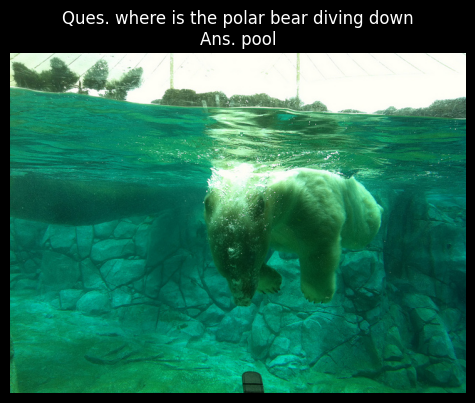

In [24]:
plotImages("/kaggle/input/coco-2017-dataset/coco2017/train2017")

1/1 [==============================] - 1s 853ms/step


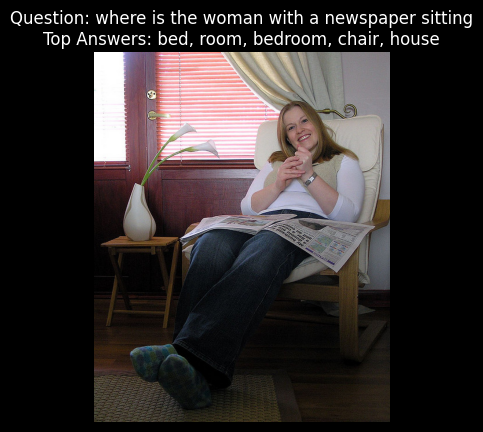

In [26]:
# Example usage of the function
image_path = "/kaggle/input/coco-2017-dataset/coco2017/train2017"+"/"+str(val_data["image_id"][150]).zfill(12) + '.jpg'
question = val_data["question"][150]
#question = "how many giraffes are in the field"
# Display the image with the question and top answers
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Question: {question}\nTop Answers: {', '.join(get_answer(image_path, question))}")
plt.show()
#plt.savefig("image.png")

In [ ]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

In [ ]:
from nltk.corpus import wordnet as wn
#Change the threshold to either 0 or 0.9
def wup_measure(word1,word2,similarity_threshold=0.9):
    word1_sem = wn.synsets(word1,pos=wn.NOUN)
    word2_sem = wn.synsets(word2,pos=wn.NOUN)
    score=0.0

    #Calculate similarity for semantic fields
    for x in word1_sem:
        for y in word2_sem:
            local_score=x.wup_similarity(y)
            if local_score > score:
                score=local_score

    #Formula for thresholded WUPS
    if score < similarity_threshold:
        weight = 0.1
    else:
        weight = 1.0

    final_score = weight * score
    return final_score

In [ ]:
def computeWups(answer_list,truth):
    score = 0
    for i in range(len(answer_list)):
        score += wup_measure(answer_list[i],truth[i])
    return (score / float(len(answer_list)))

In [ ]:
score = computeWups(predicted_class,list(preprocessed_val["answer"]))
print('WUPS Test:')
print('Accuracy with WUPS is :{:.4f}'.format(score))